Notebook to carry out basic statistics on collected data e.g. check distribution of labels, means and variances of features

In [2]:
from unpacking_data import SoberSenseDataset
import os
import json
import sys
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch as t
import numpy as np
from scipy.stats import linregress

subdirectory_path = os.path.join(os.getcwd(), 'models_and_transforms_v2')
sys.path.append(subdirectory_path)

from data_transforms_v2 import prep_transform, append_distance, append_velocity_and_acceleration

device = "cuda" if t.cuda.is_available() else "mps" if t.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


Checking various screen heights

In [2]:
data = SoberSenseDataset('pilot_data')

screen_heights = set()
for i in range(len(data)):

    height = data[i][0]["screenHeight"]

    screen_heights.add(height)

print(screen_heights)

{896, 568, 667, 844}


In [4]:
def augmentation_transform(x):
    x = append_distance(x)
    x = append_velocity_and_acceleration(x)
    return(x)

data = SoberSenseDataset('pilot_data', 
                         label_name='BAC', 
                         prep_transform=prep_transform,
                         augmentation_transform=augmentation_transform)

print("Example shape for one sample:", data[0][0].shape)

Example shape for one sample: torch.Size([8, 741])


First checking distribution of BAC across group 

Amount of counts below drink driving limit: 19


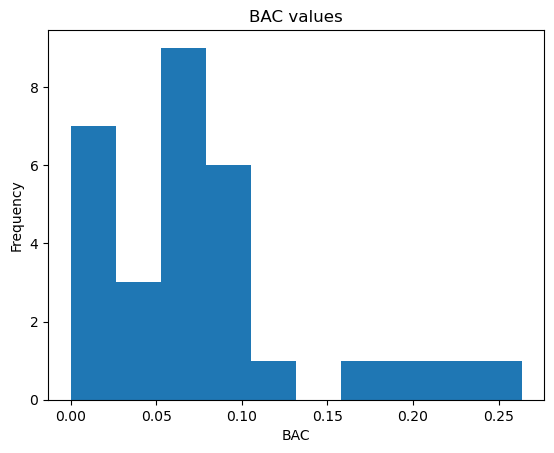

In [5]:
BAC_values = []
below_limit_count = 0
for i in range(len(data)):
    BAC_values.append(data[i][1])

    if data[i][1] < 0.08:
        below_limit_count += 1


print("Amount of counts below drink driving limit:", below_limit_count)

plt.hist(BAC_values, bins=10) 

plt.title('BAC values')
plt.xlabel('BAC')
plt.ylabel('Frequency')

plt.show()
    


Checking lengths of touch data arrays i.e. the number of touch points recorded for each sample.


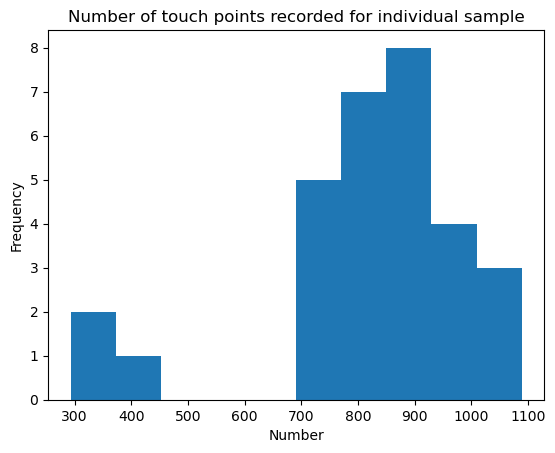

In [6]:
touchpoint_sizes = []
for i in range(len(data)):
    touchpoint_sizes.append(data[i][0].shape[-1])

plt.hist(touchpoint_sizes, bins=10) 

plt.title('Number of touch points recorded for individual sample')
plt.xlabel('Number')
plt.ylabel('Frequency')

plt.show()

May be worth cutting off any data samples below a count of 500, as they may be badly recorded. Having checked the source of these, it's NOT consistently from one tester or phone.


Checking how distance between touch point and circle changes across all data samples.

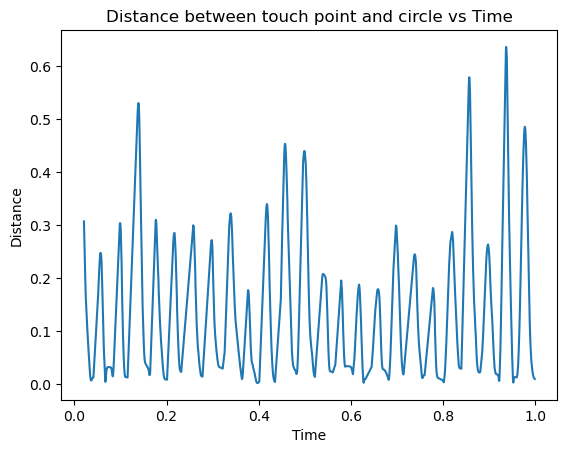

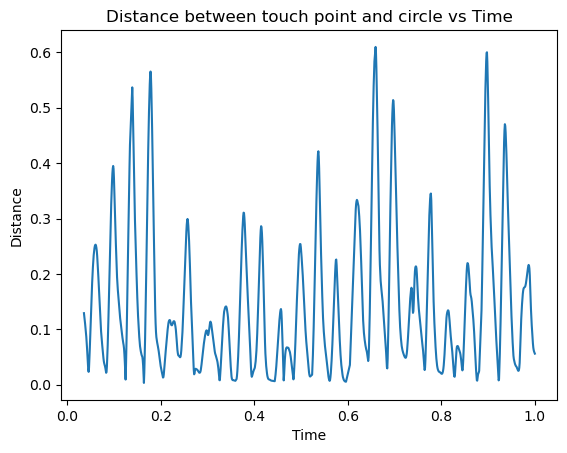

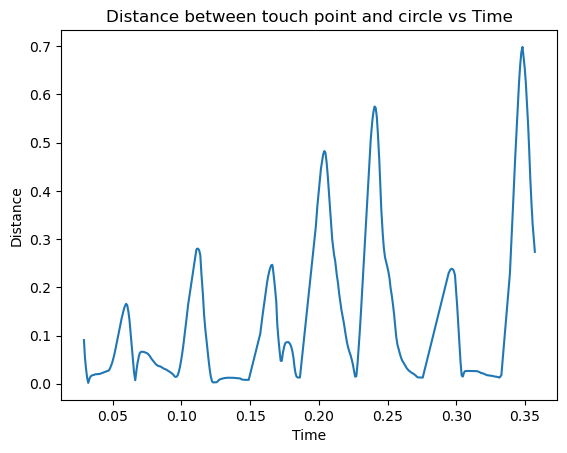

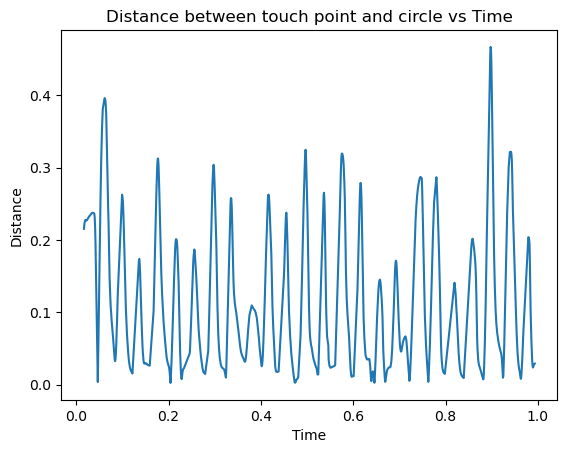

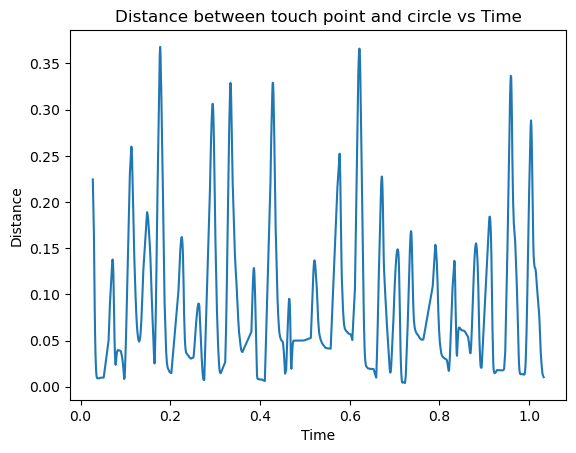

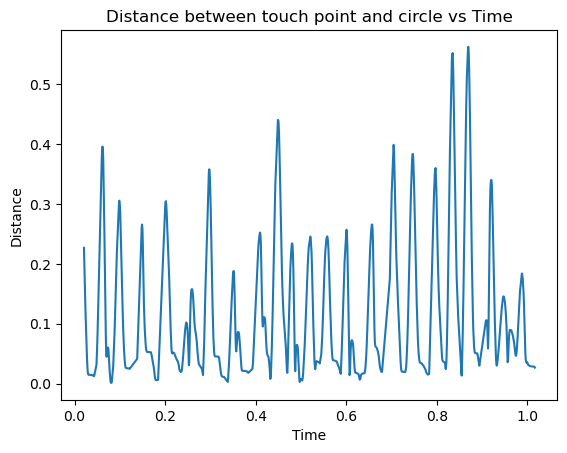

In [77]:

# Shape of sample is [num_features, p]
# features: x_touch, x_path, y_touch, y_path, time, distance

# just printing a sample 
for i in range(0, len(data), 5):

    times = data[i][0][4, :].cpu().numpy()
    distances = data[i][0][5, :].cpu().numpy()

    plt.figure(i)

    plt.plot(times, distances)
    plt.xlabel('Time')
    plt.ylabel('Distance')
    plt.title('Distance between touch point and circle vs Time')
    plt.show()

Checking average distance (between touch point and circle) vs BAC

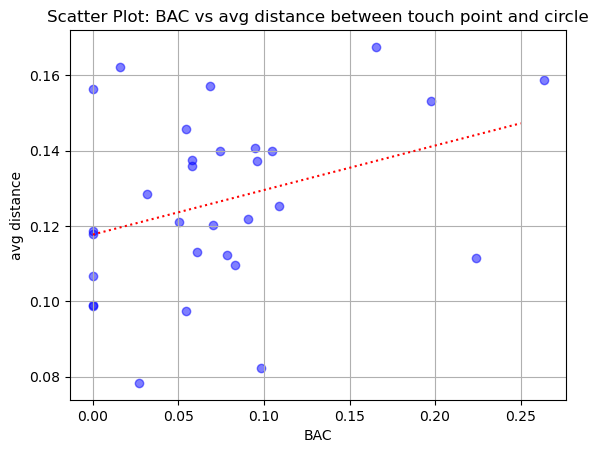

p-value: 0.07059438389539786


In [6]:
mean_distances = []
BAC_values = []

for i in range(len(data)):

    distances = data[i][0][5, :].cpu().numpy()

    mean_distances.append(np.mean(distances))

    BAC_values.append(data[i][1])


slope, intercept, r_value, p_value, std_err = linregress(BAC_values, mean_distances)


pred_distances = slope * np.linspace(0, 0.25, 5) + intercept

plt.scatter(BAC_values, mean_distances, color='blue', alpha=0.5)
plt.plot(np.linspace(0, 0.25, 5), pred_distances, color='red', linestyle=':', label='Fitted Line') 
plt.title('Scatter Plot: BAC vs avg distance between touch point and circle')
plt.xlabel('BAC')
plt.ylabel('avg distance')
plt.grid(True)


plt.show()
print("p-value:", p_value)

Checking velocity of touch movement



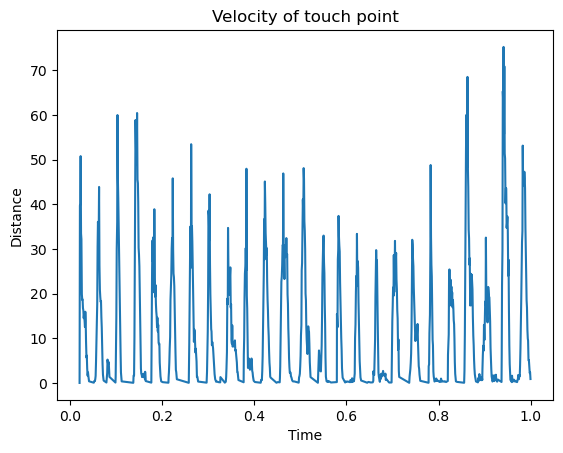

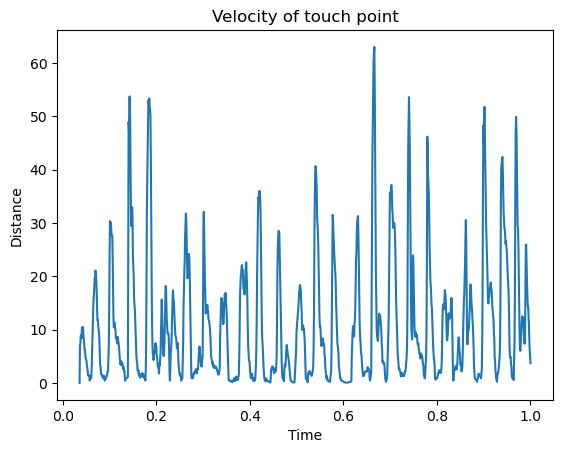

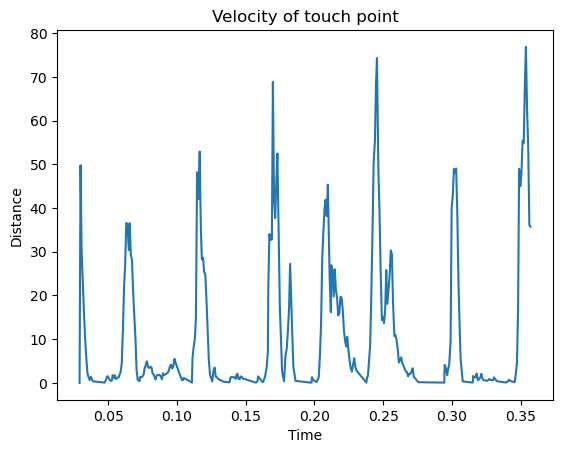

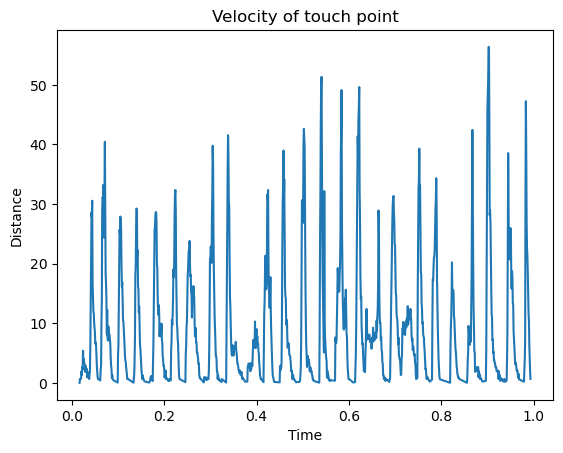

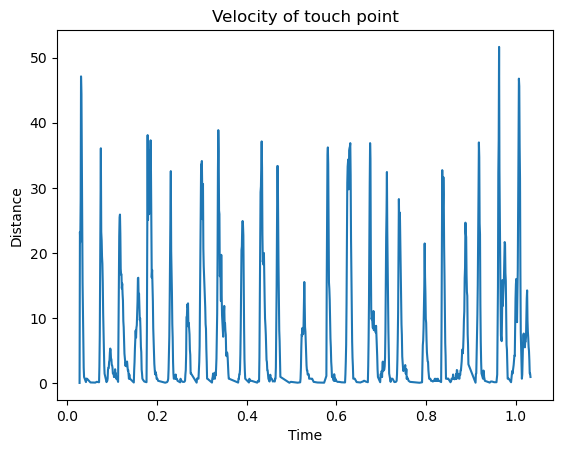

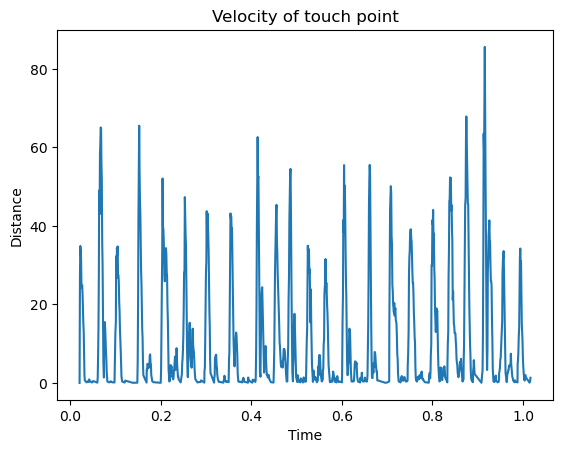

In [40]:
for i in range(0, len(data), 5):

    times = data[i][0][4, :].cpu().numpy()
    velocities = data[i][0][6, :].cpu().numpy()

    # offset avoids log(0)
    offset = 1e-6 
    log_velocities = np.log(velocities + offset)

    plt.figure(i)

    plt.plot(times, velocities)
    plt.xlabel('Time')
    plt.ylabel('Distance')
    plt.title('Velocity of touch point')
    plt.show()

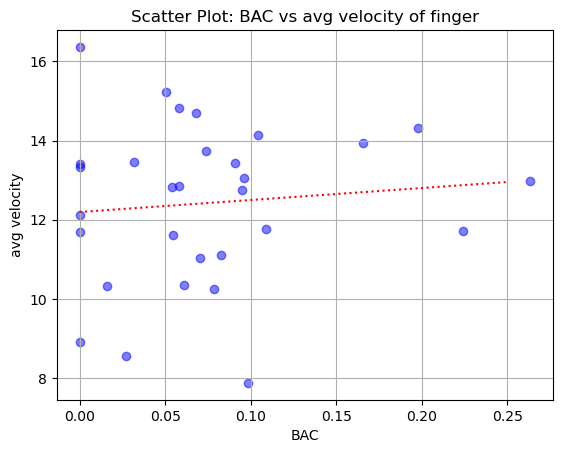

In [31]:
mean_velocity = []
BAC_values = []

for i in range(len(data)):

    velocities = data[i][0][6, :].cpu().numpy()
    mean_velocity.append(np.mean(velocities))

    BAC_values.append(data[i][1])


m, b = np.polyfit(BAC_values, mean_velocity, 1)

pred_velocities = m * np.linspace(0, 0.25, 5) + b

plt.scatter(BAC_values, mean_velocity, color='blue', alpha=0.5)
plt.plot(np.linspace(0, 0.25, 5), pred_velocities, color='red', linestyle=':', label='Fitted Line') 
plt.title('Scatter Plot: BAC vs avg velocity of finger')
plt.xlabel('BAC')
plt.ylabel('avg velocity')
plt.grid(True)


plt.show()

Checking acceleration of finger

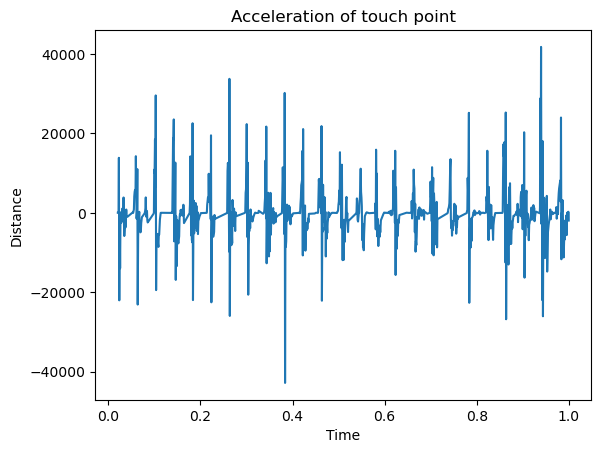

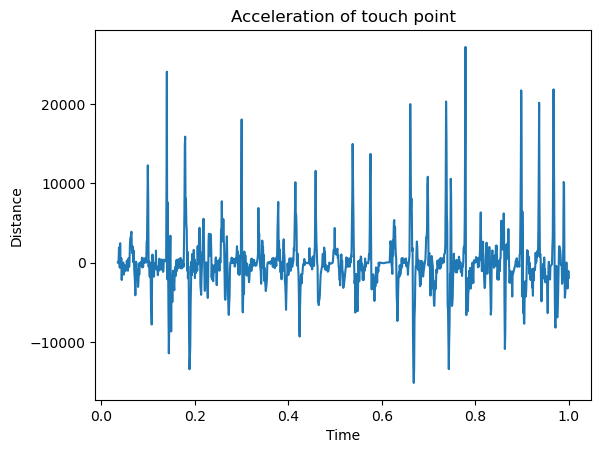

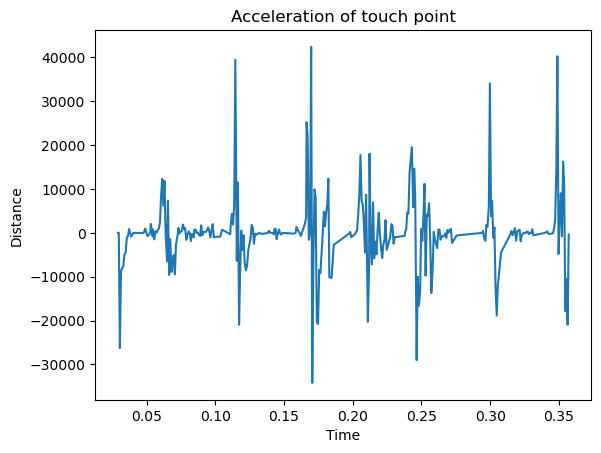

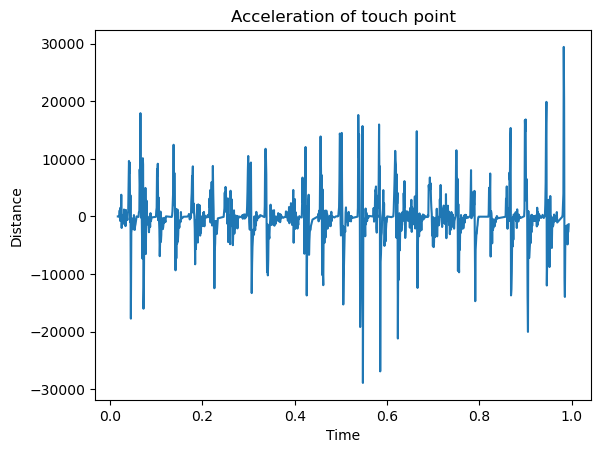

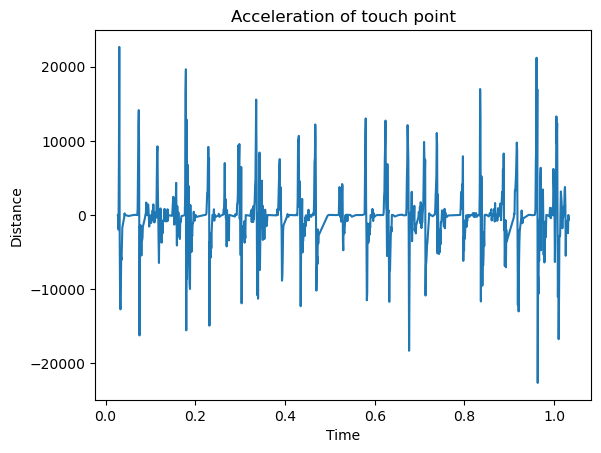

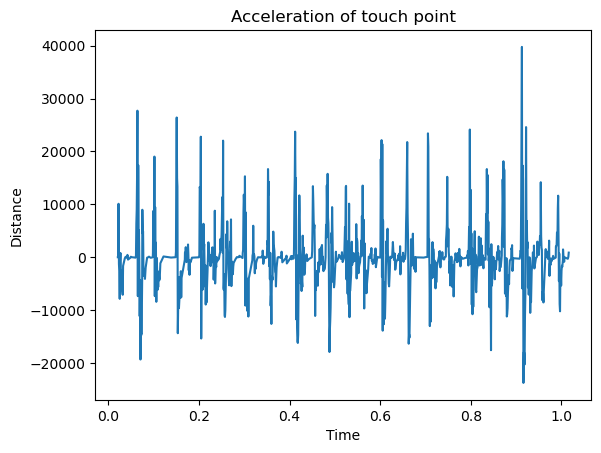

In [9]:
for i in range(0, len(data), 5):

    times = data[i][0][4, :].cpu().numpy()
    accelerations = data[i][0][7, :].cpu().numpy()

    plt.figure(i)

    plt.plot(times, accelerations)
    plt.xlabel('Time')
    plt.ylabel('Distance')
    plt.title('Acceleration of touch point')
    plt.show()

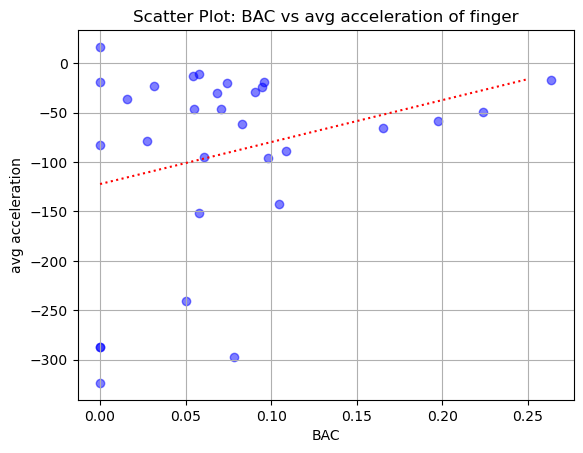

In [33]:
mean_acc = []
BAC_values = []

for i in range(len(data)):

    accelerations = data[i][0][7, :].cpu().numpy()
    mean_acc.append(np.mean(accelerations))

    BAC_values.append(data[i][1])


m, b = np.polyfit(BAC_values, mean_acc, 1)

pred_acc = m * np.linspace(0, 0.25, 5) + b

plt.scatter(BAC_values, mean_acc, color='blue', alpha=0.5)
plt.plot(np.linspace(0, 0.25, 5), pred_acc, color='red', linestyle=':', label='Fitted Line') 
plt.title('Scatter Plot: BAC vs avg acceleration of finger')
plt.xlabel('BAC')
plt.ylabel('avg acceleration')
plt.grid(True)


plt.show()